# Import dependencies

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml

from pathlib import Path

device = torch.device("cpu")

# Define functions

In [2]:
def f(X):
    x = X[:, 0]
    y = X[:, 1]
    return 0.1 + 0.5 * np.sin(x) + 0.3 * np.cos(y)

In [5]:
n_points = 50
xs = np.linspace(-np.pi, np.pi, n_points)
ys = np.linspace(-np.pi, np.pi, n_points)

xg, yg = np.meshgrid(xs, ys)
X = np.hstack([xg.reshape(-1, 1), yg.reshape(-1, 1)])

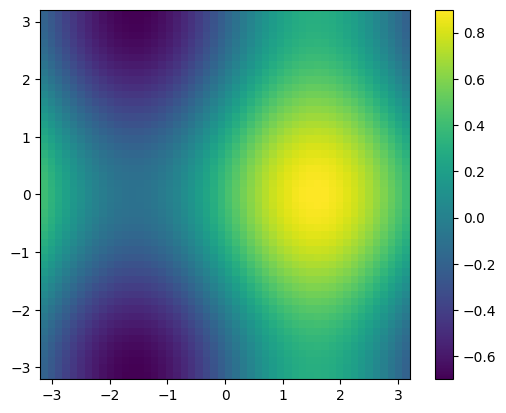

In [16]:
def plot2D(func):
    x = torch.tensor(X, dtype=float)
    with torch.no_grad():
        s = func(x).reshape(n_points, n_points)
    
    fig = plt.figure()
    ax = plt.gca()
    ax.set_aspect(1.0)
    c = ax.pcolormesh(xg, yg, s, shading="nearest")
    fig.colorbar(c, ax=ax)
    plt.show()

plot2D(f)

# Approximating with quantum circuits

In [27]:
n_qubits = 4
n_layers = 1
n_depth = 1

dev = qml.device("lightning.qubit", wires=n_qubits)

def L(w):
    # (n_layers, n_qubits, 2)
    for l in range(n_layers):
        qml.AngleEmbedding(w[l, :, 0], wires=range(n_qubits), rotation="X")
        qml.AngleEmbedding(w[l, :, 1], wires=range(n_qubits), rotation="Z")
        for j in range(n_qubits):
            qml.CNOT(wires=[j, (j+1) % n_qubits])

@qml.qnode(dev, interface="torch", diff_method="adjoint")
def circuit(inputs, weights):
    
    L(weights[0])
    
    for d in range(n_depth):
        for i in range(n_qubits):
            qml.RX(inputs[i % 2], wires=i)
        L(weights[d+1])
    
    return [qml.expval(qml.PauliZ(0))]

weight_shapes = {"weights": (n_depth + 1, n_layers, n_qubits, 2)}

In [28]:
print(qml.draw(circuit, expansion_strategy="device")(inputs=torch.arange(2),
                                                     weights=torch.rand(weight_shapes["weights"])))

0: ──RX(0.07)──RZ(0.73)─╭●───────╭X──RX(0.00)──RX(0.29)──RZ(0.45)─╭●───────╭X─┤  <Z>
1: ──RX(0.70)──RZ(0.37)─╰X─╭●────│───RX(1.00)──RX(0.41)──RZ(0.04)─╰X─╭●────│──┤     
2: ──RX(0.74)──RZ(0.40)────╰X─╭●─│───RX(0.00)──RX(0.83)──RZ(0.61)────╰X─╭●─│──┤     
3: ──RX(0.06)──RZ(0.41)───────╰X─╰●──RX(1.00)──RX(0.73)──RZ(0.02)───────╰X─╰●─┤     


In [29]:
class FreqNet(torch.nn.Module):
    def __init__(self, circuit, weight_shapes):
        super().__init__()
        # self.enc = torch.nn.Linear(1, 1, bias=False)
        self.qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)
        # self.dec = torch.nn.Linear(1, 1, bias=False)
        
    def forward(self, x):
        # x = w * x
        # x = self.enc(x)
        x = self.qlayer(x).view(-1, 1)
        # x = self.dec(x)
        
        return x

In [30]:
net = FreqNet(circuit, weight_shapes)

In [31]:
def fit(net, f, X, epochs=100):
    
    X = torch.tensor(X).float()
    
    criterion = torch.nn.MSELoss()
    optim = torch.optim.Adam(net.parameters(), lr=0.01)
    
    x = torch.linspace(-torch.pi, torch.pi, 100)
    y_exact = f(X)
    
    for e in range(epochs):
        y_pred = net(X).flatten()
        loss = criterion(y_pred, y_exact)
        if e % 10 == 0:
            print(f"epoch: {e}, loss: {loss}")
        
        optim.zero_grad()
        loss.backward()
        optim.step()

In [32]:
fit(net, f, X)

epoch: 0, loss: 0.21637728810310364
epoch: 10, loss: 0.19196105003356934
epoch: 20, loss: 0.17987839877605438
epoch: 30, loss: 0.16978922486305237


KeyboardInterrupt: 

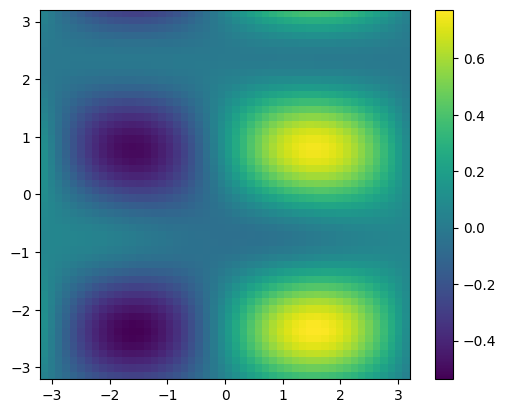

In [17]:
plot2D(net)